# Overview

The objective of this notebook is to build a function that combines acf/pacf to arima gridsearch to automatically determine ARIMA model

In [62]:
import pandas as pd
import numpy as np
import os
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', category=UserWarning)

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

%matplotlib inline

## Data Preparation

In [173]:
symbols=["SPY", "AAPL", "MSFT"]# , "AMZN", "FB", "GOOGL", "GOOG", "BRK.B", "JNJ", "JPM", "V"] #big 10 symbols to collect
pricetype = "close"
analysis_date_start = "2019-01-04"
analysis_date_end = "2020-01-01"

In [174]:
filepath = "../data/{}_daily01.csv".format("SPY")
stock_df = pd.read_csv(filepath)
#stock_df = stock_df[(stock_df.to_datetime > analysis_date_start) & (stock_df.to_datetime < analysis_date_end)]

In [175]:
stock_df["datetime"] = stock_df["to_datetime"]
stock_df["datetime"] = pd.to_datetime(stock_df["datetime"])
stock_df.drop(columns="to_datetime", inplace=True)
stock_df.index = stock_df.datetime
stock_df.drop(columns="datetime", inplace=True)

In [176]:
stock_df

,open,high,low,close,volume
datetime,,,,,
2015-10-14 01:00:00,200.18,200.8700,198.9400,199.2900,99106161
2015-10-15 01:00:00,200.08,202.3600,199.6400,202.3500,134142195
2015-10-16 01:00:00,202.83,203.2900,201.9200,203.2700,114580052
2015-10-19 01:00:00,202.50,203.3700,202.1300,203.3700,76523897
2015-10-20 01:00:00,202.85,203.8400,202.5471,203.0900,78448484
...,...,...,...,...,...
2020-12-11 01:00:00,364.90,366.7402,363.2600,366.3000,57698614
2020-12-14 01:00:00,368.64,369.8000,364.4700,364.6600,69216174
2020-12-15 01:00:00,367.40,369.5900,365.9200,369.5900,64071099


## Moving Average Crossovers

In [239]:
test_data_df = stock_df.close
rolling_days = [10, 50]
concatdf_list = [test_data_df]

for days in rolling_days:
    r_mean = test_data_df.rolling(days).mean()
    r_mean.name = f"{days}_rolling_mean"
    concatdf_list.append(r_mean)

test_data_df = pd.concat(concatdf_list, axis=1)
test_data_df.dropna(inplace=True)
test_data_df["signal"] = np.where(test_data_df["10_rolling_mean"] > test_data_df["50_rolling_mean"], 1, 0)
test_data_df["position"] = test_data_df["signal"].diff()

test_data_df.head(50)



# r_10_mean = test_data_df.rolling(first_rolling_days).mean()
# r_10_mean.name = f"{first_rolling_days}_day_rolling_mean"

# r_50_mean = test_data_df.rolling(second_rolling_days).mean()
# r_50_mean.name = f"{second_rolling_days}_day_rolling_mean"

# test_data_df = pd.concat([test_data_df, r_10_mean, r_50_mean], axis=1)
# test_data_df.head(50)

,close,10_rolling_mean,50_rolling_mean,signal,position
datetime,,,,,
2015-12-23 01:00:00,206.0200,203.97824,206.550624,0,NaN
2015-12-24 01:00:00,205.6800,203.95924,206.678424,0,0.0
2015-12-28 01:00:00,205.2100,204.29224,206.735624,0,0.0
2015-12-29 01:00:00,207.4000,204.74216,206.818224,0,0.0
2015-12-30 01:00:00,205.9300,204.83208,206.869424,0,0.0
2015-12-31 01:00:00,203.8700,204.41608,206.885024,0,0.0
2016-01-04 01:00:00,201.0192,204.03200,206.868408,0,0.0
2016-01-05 01:00:00,201.3600,204.16592,206.790408,0,0.0
2016-01-06 01:00:00,198.8200,203.88092,206.616608,0,0.0


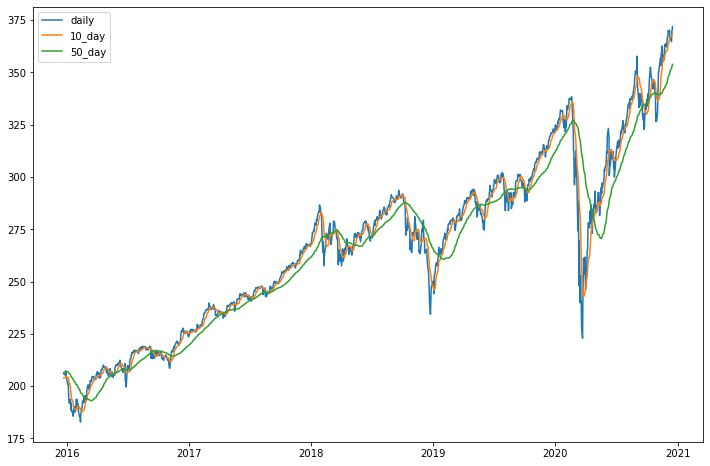

In [244]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(test_data_df.close, label="daily")
ax.plot(test_data_df["10_rolling_mean"], label="10_day")
ax.plot(test_data_df["50_rolling_mean"], label="50_day")
plt.legend()

## Auto GridSearch ARIMA

In [ ]:
def GridSearch_ARIMA(data, column, start, train_length, forecast_length, p_max, q_max, r_max):
    clean_data = data[column][start:].iloc[:(train_length+forecast_length)]
    true_data = clean_data[train_length:] #get y_true
    train_data = clean_data[:train_length] #set training data
    
    order_list = permutate_list(p_max, q_max, r_max)
    
    for order in order_list:
        model = ARIMA(train_data, order=order)
        results = model.fit()
        prediction = results.forecast(forecast_length)


In [142]:
def permutate_orders(p, d, q):
    p_list = range(0, p)
    d_list = range(0, d)
    q_list = range(0, q)
    permutate_list = []
    
    for p_val in p_list:
        for d_val in d_list:
            for q_val in q_list:
                permutate_list.append((p_val, d_val, q_val))
                
    return permutate_list

In [113]:
# Create a function that builds and plots ARIMA

def ARIMA_visualize(data, column, start, train_length, forecast_length, order=(1,0,0)):
    clean_data = data[column][start:].iloc[:(train_length+forecast_length)] #reformat input data
    true_data = clean_data[train_length:] #get y_true
    train_data = clean_data[:train_length] #set training data
    
    model = ARIMA(train_data, order=order)
    results = model.fit()
    prediction = results.forecast(forecast_length)
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(clean_data.reset_index()["close"])
    ax.plot(results.fittedvalues.reset_index()[0][5:])
    ax.plot(prediction)
    
    return prediction

25    277.810898
26    277.355400
27    279.537982
28    281.469311
29    280.907899
dtype: float64

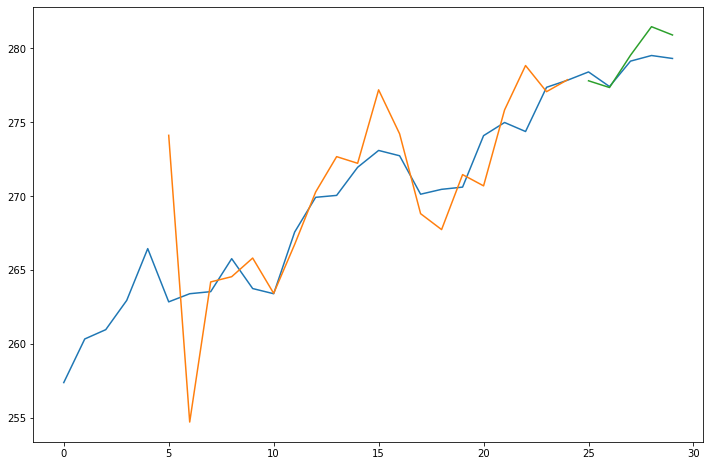

In [121]:
ARIMA_visualize(stock_df, "close", "2019-01-14", 25, 5, order=(6,4,3))

In [115]:
# Create a function that builds and plots ARIMA

def ARIMA_log_visualize(data, column, start, train_length, forecast_length, order=(1,0,0)):
    clean_data = data[column][start:].iloc[:(train_length+forecast_length)] #reformat input data
    clean_data = np.log(clean_data)
    true_data = clean_data[train_length:] #get y_true
    train_data = clean_data[:train_length] #set training data
    
    model = ARIMA(train_data, order=order)
    results = model.fit()
    prediction = results.forecast(forecast_length)
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(clean_data.reset_index()["close"])
    ax.plot(results.fittedvalues.reset_index()[0][5:])
    ax.plot(prediction)
    
    return prediction

25    5.629425
26    5.633314
27    5.635990
28    5.639284
29    5.642333
dtype: float64

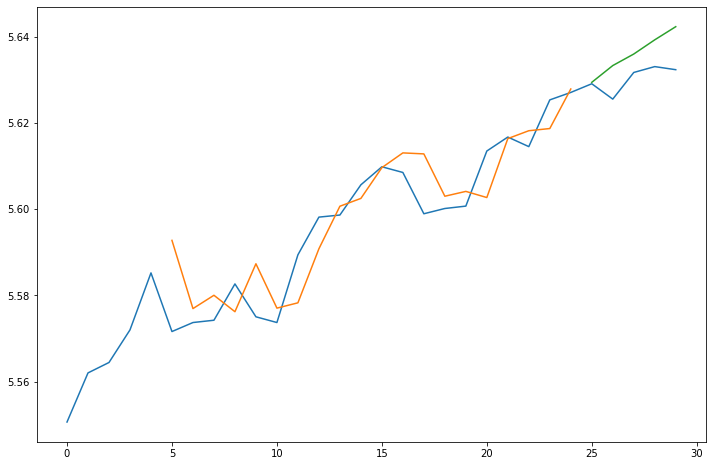

In [116]:
ARIMA_log_visualize(stock_df, "close", "2019-01-14", 25, 5, order=(2,2,2))

In [96]:
p

1

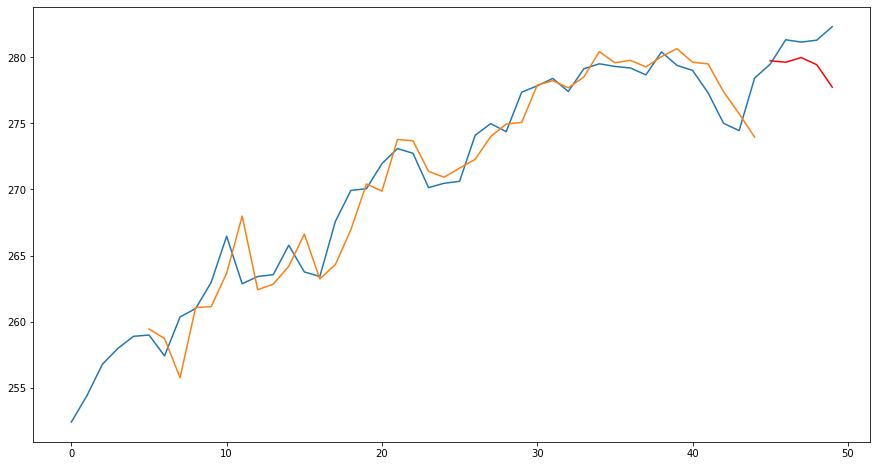

In [172]:
# Generate 
prediction_length = 5

test_series = stock_df["close"][:50]
test_model = ARIMA(test_series[:-prediction_length], order=(7,3,6))
result = test_model.fit()
predict = result.forecast(prediction_length)


fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(test_series.reset_index()["close"])
plt.plot(result.fittedvalues.reset_index()[0][5:])
plt.plot(predict, color="red")


In [162]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                  245
Model:                 ARIMA(7, 3, 6)   Log Likelihood                -537.610
Date:                Mon, 21 Dec 2020   AIC                           1103.220
Time:                        13:05:30   BIC                           1152.065
Sample:                             0   HQIC                          1122.897
                                - 245                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0892      0.340     -3.201      0.001      -1.756      -0.422
ar.L2         -0.3744      0.185     -2.020      0.043      -0.738      -0.011
ar.L3         -1.0515      0.156     -6.749      0.000      -1.357      -0.746
ar.L4         -1.0555      0.367     -2.879      0.004      -1.774      -0.337
ar.L5         -0.1519      0.109     -1.396      0.163      -0.365       0.061
ar.L6         -0.0934      0.106     -0.878      0.380      -0.302       0.115
ar.L7         -0.0134      0.063     -0.214      0.831      -0.136       0.109
ma.L1         -0.9664      0.532     -1.817      0.069      -2.009       0.076
ma.L2         -0.7815      0.953     -0.820      0.412      -2.648       1.085
ma.L3          1.5056      0.426      3.534      0.000       0.671       2.341
ma.L4         -0.7595      0.696     -1.091      0.275      -2.124       0.605
ma.L5         -0.9679      1.110     -0.872      0.383      -3.144       1.208
ma.L6          0.9744      0.551      1.767      0.077      -0.106       2.055
sigma2         4.6065      1.068      4.315      0.000       2.514       6.699
===================================================================================
Ljung-Box (Q):                       47.28   Jarque-Bera (JB):                79.63
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                            -0.78
Prob(H) (two-sided):                  0.53   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

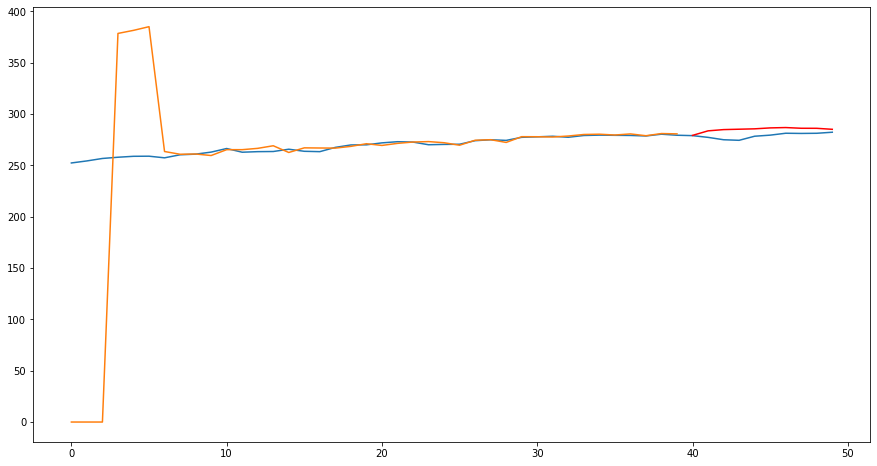

In [170]:
# Generate 
prediction_length = 10

test_series = stock_df["close"][:50]
test_model = SARIMAX(test_series[:-prediction_length], seasonal_order=(5,2,3,3))
result = test_model.fit()
predict = result.forecast(prediction_length)


fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(test_series.reset_index()["close"])
plt.plot(result.fittedvalues.reset_index()[0])
plt.plot(predict, color="red")

In [171]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:                                     close   No. Observations:                   40
Model:             SARIMAX(1, 0, 0)x(5, 2, [1, 2, 3], 3)   Log Likelihood                 -68.877
Date:                                   Mon, 21 Dec 2020   AIC                            157.753
Time:                                           13:11:48   BIC                            173.017
Sample:                                                0   HQIC                           162.959
                                                    - 40                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5494      0.249      2.206      0.027       0.061       1.038
ar.S.L3       -1.0407      1.132     -0.919      0.358      -3.260       1.178
ar.S.L6       -1.4435      1.581     -0.913      0.361      -4.541       1.654
ar.S.L9       -0.9073      1.842     -0.492      0.622      -4.518       2.704
ar.S.L12      -0.3924      1.416     -0.277      0.782      -3.167       2.382
ar.S.L15       0.1015      0.785      0.129      0.897      -1.437       1.640
ma.S.L3       -0.8361     81.364     -0.010      0.992    -160.307     158.635
ma.S.L6        0.8198     15.446      0.053      0.958     -29.453      31.093
ma.S.L9       -0.9799     83.122     -0.012      0.991    -163.895     161.935
sigma2         1.3555    113.967      0.012      0.991    -222.017     224.728
===================================================================================
Ljung-Box (Q):                       23.47   Jarque-Bera (JB):                 0.74
Prob(Q):                              0.89   Prob(JB):                         0.69
Heteroskedasticity (H):               0.30   Skew:                             0.11
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
predict.reset_index()

datetime
2019-02-11 01:00:00    270.722321
2019-02-12 01:00:00    270.697468
2019-02-13 01:00:00    273.761570
2019-02-14 01:00:00    274.765268
2019-02-15 01:00:00    274.662802
                          ...    
2019-11-18 01:00:00    311.854192
2019-11-19 01:00:00    311.851973
2019-11-20 01:00:00    311.827888
2019-11-21 01:00:00    310.949204
2019-11-22 01:00:00    310.424208
Length: 200, dtype: float64

In [24]:
result.fittedvalues

datetime
2019-01-04 01:00:00    288.255743
2019-01-07 01:00:00    252.500296
2019-01-08 01:00:00    254.519357
2019-01-09 01:00:00    256.874639
2019-01-10 01:00:00    258.077778
                          ...    
2019-12-24 01:00:00    321.172621
2019-12-26 01:00:00    321.074748
2019-12-27 01:00:00    322.938416
2019-12-30 01:00:00    322.646077
2019-12-31 01:00:00    321.031965
Length: 250, dtype: float64

In [25]:
test_series

datetime
2019-01-04 01:00:00    252.39
2019-01-07 01:00:00    254.38
2019-01-08 01:00:00    256.77
2019-01-09 01:00:00    257.97
2019-01-10 01:00:00    258.88
                        ...  
2019-12-24 01:00:00    321.23
2019-12-26 01:00:00    322.94
2019-12-27 01:00:00    322.86
2019-12-30 01:00:00    321.08
2019-12-31 01:00:00    321.86
Name: close, Length: 250, dtype: float64

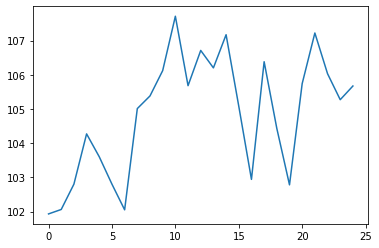

In [42]:
plt.plot(test_values)

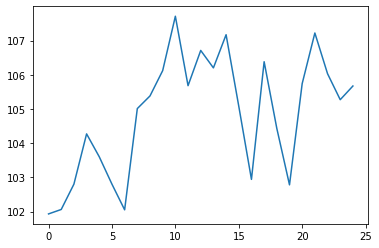

In [56]:
diff_test_values = pd.DataFrame(stock_df[pricetype].values[:25])
diff_test_values = diff_test_values
plt.plot(diff_test_values)

In [144]:
model = ARIMA(test_values, order=(2,2,2)) #fit and predictarima_model = model.fit()
arima_model = model.fit()
model_prediction = arima_model.forecast(steps=5)

NameError: name 'test_values' is not defined

In [74]:
model_prediction

array([105.76119155, 105.89078098, 106.11395383, 106.23085007,
       106.41044929])

In [81]:
type(arima_model)

statsmodels.tsa.arima.model.ARIMAResultsWrapper

In [91]:
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.seasonal import STL

In [118]:
stock_df.index

DatetimeIndex(['2019-01-04 01:00:00', '2019-01-07 01:00:00',
               '2019-01-08 01:00:00', '2019-01-09 01:00:00',
               '2019-01-10 01:00:00', '2019-01-11 01:00:00',
               '2019-01-14 01:00:00', '2019-01-15 01:00:00',
               '2019-01-16 01:00:00', '2019-01-17 01:00:00',
               ...
               '2019-12-17 01:00:00', '2019-12-18 01:00:00',
               '2019-12-19 01:00:00', '2019-12-20 01:00:00',
               '2019-12-23 01:00:00', '2019-12-24 01:00:00',
               '2019-12-26 01:00:00', '2019-12-27 01:00:00',
               '2019-12-30 01:00:00', '2019-12-31 01:00:00'],
              dtype='datetime64[ns]', name='datetime', length=250, freq=None)

In [119]:
test_values2 =stock_df[pricetype]
test_values2[:40]

datetime
2019-01-04 01:00:00    252.39
2019-01-07 01:00:00    254.38
2019-01-08 01:00:00    256.77
2019-01-09 01:00:00    257.97
2019-01-10 01:00:00    258.88
2019-01-11 01:00:00    258.98
2019-01-14 01:00:00    257.40
2019-01-15 01:00:00    260.35
2019-01-16 01:00:00    260.98
2019-01-17 01:00:00    262.96
2019-01-18 01:00:00    266.46
2019-01-22 01:00:00    262.86
2019-01-23 01:00:00    263.41
2019-01-24 01:00:00    263.55
2019-01-25 01:00:00    265.78
2019-01-28 01:00:00    263.76
2019-01-29 01:00:00    263.41
2019-01-30 01:00:00    267.58
2019-01-31 01:00:00    269.93
2019-02-01 01:00:00    270.06
2019-02-04 01:00:00    271.96
2019-02-05 01:00:00    273.10
2019-02-06 01:00:00    272.74
2019-02-07 01:00:00    270.14
2019-02-08 01:00:00    270.47
2019-02-11 01:00:00    270.62
2019-02-12 01:00:00    274.10
2019-02-13 01:00:00    274.99
2019-02-14 01:00:00    274.38
2019-02-15 01:00:00    277.37
2019-02-19 01:00:00    277.85
2019-02-20 01:00:00    278.41
2019-02-21 01:00:00    277.42
2

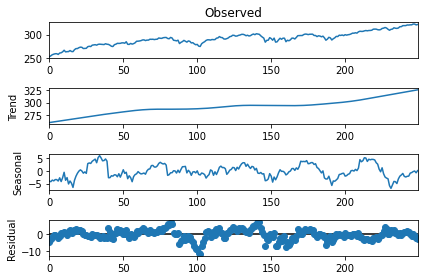

In [138]:
res = STL(test_values2.values, period=40).fit()
res.plot()
plt.show()

In [145]:
stlf = STLForecast(test_values2.values, ARIMA, model_kwargs={"order": (2, 1, 2)},period=40)
res = stlf.fit()
forecasts = res.forecast(5)

In [146]:
forecasts

array([326.26776488, 325.37289933, 325.63848804, 326.85077111,
       326.85995751])

In [ ]:
statsmodels.tsa.arima.model.ARIMA

In [132]:
res = sm.tsa.arma_order_select_ic(test_values2.values, ic=["aic", "bic"], trend="nc")


C:\Users\Yung\Anaconda3\envs\fitsnbits\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Yung\Anaconda3\envs\fitsnbits\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and st

(1, 1)

In [134]:

res.bic_min_order

(1, 1)

In [133]:
res.aic_min_order

(2, 1)

In [100]:
stock_df.index = stock_df.to_datetime

In [131]:

import statsmodels.api as sm
import numpy as np
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
arparams = np.r_[1, -arparams]
maparam = np.r_[1, maparams]
nobs = 250
np.random.seed(2014)
y = arma_generate_sample(arparams, maparams, nobs)
res = sm.tsa.arma_order_select_ic(y, ic=["aic", "bic"], trend="nc")
res.aic_min_order
res.bic_min_order

C:\Users\Yung\Anaconda3\envs\fitsnbits\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Yung\Anaconda3\envs\fitsnbits\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and st

(1, 2)

In [ ]:
arima_model()

In [44]:
from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api as sm
import numpy as np
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
arparams = np.r_[1, -arparams]
maparam = np.r_[1, maparams]
nobs = 250
np.random.seed(2014)
y = arma_generate_sample(arparams, maparams, nobs)
res = sm.tsa.arma_order_select_ic(y, ic=["aic", "bic"], trend="nc")
res.aic_min_order
res.bic_min_order

C:\Users\Yung\Anaconda3\envs\fitsnbits\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Yung\Anaconda3\envs\fitsnbits\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and st

(1, 2)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


C:\Users\Yung\Anaconda3\envs\fitsnbits\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
C:\Users\Yung\Anaconda3\envs\fitsnbits\lib\site-packages\statsmodels\tsa\stattools.py:666: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,
C:\Users\Yung\Anaconda3\envs\fitsnbits\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
C:\Users\Yung\Anaconda3\envs\fitsnbits\lib\site-packages\statsmodels\tsa\stattools.py:666: FutureWarning: fft=True will become the default aft

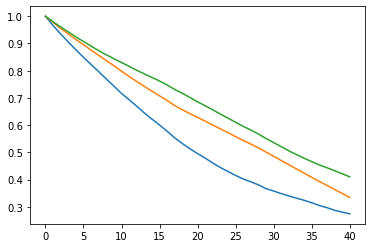

In [13]:
for symbol in symbols:
    filepath = "../data/{}_daily01.csv".format(symbol)
    stock_df = pd.read_csv(filepath)
    stock_df = stock_df[(stock_df.to_datetime > analysis_date_start) & (stock_df.to_datetime < analysis_date_end)][pricetype]
    acf_result = acf(stock_df)
    print(type(acf_result))
    plt.plot(acf_result)
#     plot_title = "{} ACF and PACF".format(symbol)
#     fig, ax = plt.subplots(1,2, figsize=(9,6))
#     plot_acf(stock_df.values, ax=ax[0]);
#     plot_pacf(stock_df.values, ax=ax[1]);
#     fig.suptitle(plot_title, size=18)

<class 'tuple'>
(41,)
[ 1.00000000e+00  9.69889222e-01  3.10493108e-02  1.27593124e-02
 -7.61310292e-03  9.13116680e-03 -1.07554083e-03 -4.39077395e-04
 -3.44250352e-02 -4.18381161e-03 -2.84199365e-02  5.05579508e-02
 -2.11369744e-02 -3.39454063e-02  1.40001132e-02  1.33979489e-02
 -3.67155540e-02 -4.88355707e-02  4.39294617e-02  2.26902390e-02
  2.36965710e-02  1.22318954e-03 -3.87526898e-02  1.96551049e-02
  2.91359818e-02  3.90655524e-05  8.56103129e-03  3.86883899e-02
 -8.48831380e-03 -5.88035645e-02  8.52226351e-02 -1.76684073e-02
  1.23886459e-02  1.24861218e-02 -6.60061268e-03 -2.71455308e-02
 -3.51353040e-02  5.21070203e-02 -3.74670394e-02  2.96713775e-02
  1.46152344e-02]
(41, 2)
[[ 1.          1.        ]
 [ 0.84593022  1.09384823]
 [-0.0929097   0.15500832]
 [-0.11119969  0.13671832]
 [-0.13157211  0.1163459 ]
 [-0.11482784  0.13309017]
 [-0.12503455  0.12288347]
 [-0.12439808  0.12351993]
 [-0.15838404  0.08953397]
 [-0.12814282  0.11977519]
 [-0.15237894  0.09553907]
 [-0.

C:\Users\Yung\Anaconda3\envs\fitsnbits\lib\site-packages\statsmodels\tsa\stattools.py:1021: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
C:\Users\Yung\Anaconda3\envs\fitsnbits\lib\site-packages\statsmodels\tsa\stattools.py:1021: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
C:\Users\Yung\Anaconda3\envs\fitsnbits\lib\site-packages\statsmodels\tsa\stattools.py:1021: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,


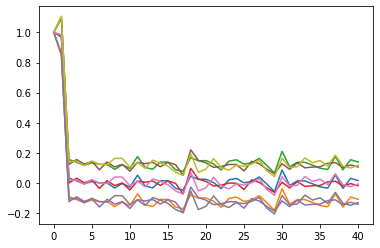

In [28]:
for symbol in symbols:
    filepath = "../data/{}_daily01.csv".format(symbol)
    stock_df = pd.read_csv(filepath)
    stock_df = stock_df[(stock_df.to_datetime > analysis_date_start) & (stock_df.to_datetime < analysis_date_end)][pricetype]
    pacf_result = pacf(stock_df, alpha=0.05)
    print(type(pacf_result))
    print(pacf_result[0].shape)
    print(pacf_result[0])
    print(pacf_result[1].shape)
    print(pacf_result[1])
    plt.plot(pacf_result[0])
    plt.plot(pacf_result[1])

In [29]:
def ARIMA_gridsearch(p, d_max:int, q_max:int, data, prediction_length):
    return_list = [] #initialize return list
    train_data_idx = len(data) - prediction_length
    train = data[:train_data_idx] #slice train and test data
    test = data[train_data_idx:]
    d_range = range(0, d_max+1)
    q_range = range(1, q_max+1)
    for d in d_range:
        for q in q_range:
            model = ARIMA(train, order=(p,d,q)) #fit and predict
            arima_model = model.fit()
            model_prediction = arima_model.forecast(steps=prediction_length)
            warning = arima_model.mle_retvals["warnflag"]
            convergence = arima_model.mle_retvals["converged"]
            rmse_result = np.sqrt(mean_squared_error(test, model_prediction)) #get rmse
            return_list.append([p,d,q,convergence, warning, rmse_result])
    return sorted(return_list, key=lambda x: (x[-1], x[-2], (x[-3]*-1))) #order by RMSE, no warning, and convergence

In [32]:
for symbol in symbols:
    filepath = "../data/{}_daily01.csv".format(symbol)
    stock_df = pd.read_csv(filepath)
    stock_df = stock_df[(stock_df.to_datetime > analysis_date_start) & (stock_df.to_datetime < analysis_date_end)][pricetype]
    grid_result = ARIMA_gridsearch(4, 3, 4, stock_df.values, 30)
    print(symbol)
    print(grid_result)

SPY
[[4, 2, 1, True, 0, 2.364195222441467], [4, 2, 4, False, 1, 2.376068706060797], [4, 2, 2, True, 0, 2.380089872772744], [4, 2, 3, False, 1, 2.4460391708999296], [4, 3, 3, False, 1, 3.9086198126718372], [4, 3, 4, False, 1, 4.189635760763447], [4, 1, 4, False, 1, 4.925671652018947], [4, 1, 1, True, 0, 6.067742281246259], [4, 1, 2, False, 1, 6.1541845561440125], [4, 1, 3, False, 1, 6.281136047846952], [4, 0, 4, False, 1, 6.430454524063897], [4, 0, 2, False, 1, 7.022610546643211], [4, 0, 3, False, 1, 7.376284352611175], [4, 0, 1, True, 0, 7.94746935809074], [4, 3, 1, True, 0, 9.754326202553715], [4, 3, 2, True, 0, 10.4106753798811]]
AAPL
[[4, 2, 1, True, 0, 1.5256281211765224], [4, 2, 3, True, 0, 1.529443294207699], [4, 2, 4, True, 0, 1.5345266573716634], [4, 1, 3, False, 1, 1.5484746035480874], [4, 1, 2, False, 1, 1.603789046103891], [4, 1, 1, True, 0, 1.6051689375782199], [4, 1, 4, False, 1, 1.6437753262038601], [4, 2, 2, True, 0, 1.9640255022231319], [4, 3, 1, True, 0, 2.785698003552